In [1]:
import matplotlib
import seaborn
import pandas
import networkx
import tqdm
import gzip
import igraph

from collections import Counter

%matplotlib inline

In [2]:
ecosystems = ['pypi', 'npm', 'cran']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}

In [3]:
def igraph_to_networkx(graph):
    ngraph = networkx.DiGraph() if graph.is_directed() else networkx.Graph()
    nodes = graph.vs['name']
    edges = ((nodes[source], nodes[target]) for source, target in graph.get_edgelist())
    ngraph.add_nodes_from(nodes)
    ngraph.add_edges_from(edges)
    return ngraph

In [4]:
graphs = {}

for ecos in ecosystems:
    with gzip.GzipFile('../../{}/data/packages.csv.gz'.format(ecos)) as f:
        packages = pandas.read_csv(f, index_col=[0,1])
    with gzip.GzipFile('../../{}/data/deps.csv.gz'.format(ecos)) as f:
        deps = pandas.read_csv(f)

    # Take latest version of each package
    packages = packages.sort_values('time').groupby(level=0, sort=False).tail(1)
    deps = packages.merge(deps, how='inner', left_index=True, right_on=['package', 'version']).dropna()

    # Filter out dependencies that are not registered packages
    deps = packages.reset_index().merge(deps, how='inner', left_on='package', right_on='dependency', suffixes=('_2', ''))
    
    # Construct graph
    graph = igraph.Graph(directed=True)
    graph.add_vertices(packages.index.get_level_values('package'))
    edges = [(row.package, row.dependency) for row in deps[['package', 'dependency']].itertuples()]
    graph.add_edges(edges)
    
    graphs[ecos] = graph
    

## Packages and Dependencies

In [5]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    data[ecos]['packages'] = graph.vcount()
    data[ecos]['dependencies'] = graph.ecount()
    data[ecos]['pkg_with_deps'] = len([True for d in graph.outdegree() if d > 0])
    data[ecos]['pkg_with_rev_deps'] = len([True for d in graph.indegree() if d > 0])
    data[ecos]['pkg_non_isolated'] = len([True for d in graph.degree() if d > 0])
    data[ecos]['pkg_isolated'] = len([True for d in graph.degree() if d == 0])
df = pandas.DataFrame.from_dict(data, orient='index')
df

,packages,pkg_isolated,pkg_non_isolated,pkg_with_deps,pkg_with_rev_deps,dependencies
cran,9568,7119,2449,1921,872,3770
npm,317160,109796,207364,185228,66129,725450
pypi,82134,77349,4785,3344,1739,10063


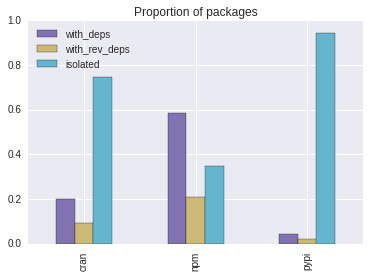

In [6]:
df['with_deps'] = df['pkg_with_deps'] / df['packages']
df['with_rev_deps'] = df['pkg_with_rev_deps'] / df['packages']
df['isolated'] = df['pkg_isolated'] / df['packages']
df[['with_deps', 'with_rev_deps', 'isolated']].plot.bar(title='Proportion of packages', color=seaborn.color_palette()[3:])

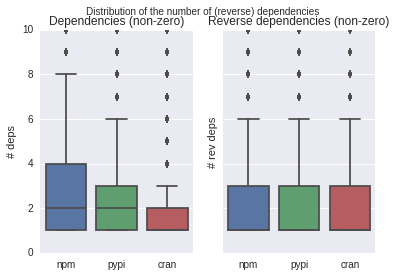

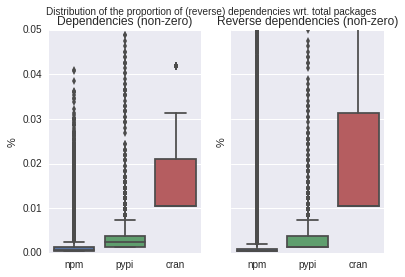

In [7]:
data_in = []
data_in_p = []
data_out = []
data_out_p = []

for ecos, graph in graphs.items():
    n = graph.vcount()
    for d in graph.outdegree():
        if d > 0:
            data_out.append((ecos, d))
            data_out_p.append((ecos, 100 * d / n))
            
    for d in graph.indegree():
        if d > 0:
            data_in.append((ecos, d))
            data_in_p.append((ecos, 100 * d / n))

fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            
fig.suptitle('Distribution of the number of (reverse) dependencies')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out), ax=axes[0])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# deps')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in), ax=axes[1])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# rev deps')
ax.set_title('Reverse dependencies (non-zero)')


fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            
fig.suptitle('Distribution of the proportion of (reverse) dependencies wrt. total packages')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out_p), ax=axes[0])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in_p), ax=axes[1])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Reverse dependencies (non-zero)')

In [8]:
print('Most required packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.indegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

print()

print('Most dependent packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.outdegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

Most required packages
npm : lodash (23306), request (14571), async (14089), underscore (11976), commander (9409), express (9365), chalk (8964), debug (8463), bluebird (7261), mkdirp (6326), 
pypi : requests (593), numpy (526), six (435), pytest (259), coverage (245), scipy (221), matplotlib (179), pytest-cov (158), check-manifest (154), mock (144), 
cran : Rcpp (468), ggplot2 (126), httr (84), dplyr (74), rJava (62), Matrix (55), stringr (51), data.table (49), jsonlite (43), plyr (42), 

Most dependent packages
npm : mikolalysenko-hoarders (389), terrible-lodash (309), smasher (130), lodash-modularized (129), compute.io (122), bb-lp-cli (115), smashing-dev-tool (114), brainfock (114), cordova-plugin-require-bluetoothle (112), files-and-folders-server (110), 
pypi : invenio-records-rest (50), invenio-migrator (49), invenio-openaire (48), invenio-previewer (47), invenio-communities (46), gnocchi (43), invenio-logging (40), cameo (40), invenio-files-rest (39), jsonresolver (38), 
cran : 

## Connected components

In [9]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    for component, size in Counter(len(component) for component in graph.components(mode=igraph.WEAK)).items():
        data[ecos][component] = size
df = pandas.DataFrame.from_dict(data)
print('Number of (weakly) connected components by component size')
df.T.fillna(0)

Number of (weakly) connected components by component size


,1,2,3,4,5,6,7,8,9,10,...,27,28,32,35,36,41,106,2126,4349,201593
cran,7119.0,76.0,30.0,8.0,1.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
npm,109810.0,1486.0,296.0,119.0,40.0,32.0,9.0,11.0,11.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
pypi,77349.0,140.0,17.0,4.0,3.0,3.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(0.83695179574305245, 1000000.0)

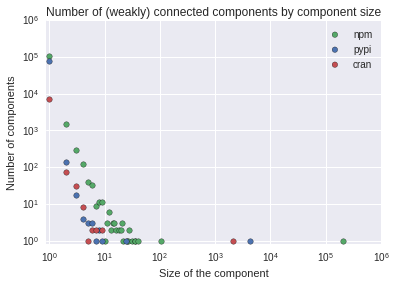

In [10]:
d = df.reset_index().rename(columns={'index': 'component'})
d = pandas.melt(d, id_vars='component', value_vars=['cran', 'npm', 'pypi'], var_name='ecosystem', value_name='size').dropna()

ax = None
for i, ecos in enumerate(graphs.keys()):
    kwargs = {
        'x': 'component', 
        'y': 'size',
        'label': ecos,
        'logx': True,
        'logy': True,
        's': 30,
        'color': COLORS[ecos]
    }
    if ax:
        kwargs['ax'] = ax
        
    ax = d.query('ecosystem == "{}"'.format(ecos)).plot.scatter(**kwargs)
ax.set_xlabel('Size of the component')
ax.set_ylabel('Number of components')
ax.set_title('Number of (weakly) connected components by component size')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

**Next cell ignores the biggest component of NPM!!**

In [11]:
data = []
for ecos, graph in graphs.items():
    # Convert igraph to networkx
    graph = igraph_to_networkx(graph).to_undirected()
    components = networkx.connected_components(graph)
    for component in filter(lambda c: 200000 > len(c) > 1, components):
        subgraph = graph.subgraph(component)
        apl = networkx.average_shortest_path_length(subgraph)
        data.append((ecos, len(component), apl))

**The biggest component of NPM was NOT considered by the previous cell. The computation for this component takes far too long (several weeks). Thus, an estimation based on a subset of source nodes is done. This estimation takes on average 10 minutes. Following cell can be parametrized to avoid this computation and to use the latest estimation which is hard-written in the code.**

In [12]:
use_cache = True

if not use_cache:
    from random import sample
    graph = igraph_to_networkx(graphs['npm']).to_undirected()
    max_component = max(networkx.connected_components(graph), key=len)
    subgraph = graph.subgraph(max_component)

    print('--')

    n_paths = 0
    sum_of_lengths = 0
    #sources = sample(subgraph.nodes(), 2000)
    sources = sorted(subgraph.degree_iter(), key=lambda x: x[1], reverse=True)[:2500]

    for source, degree in tqdm.tqdm_notebook(sources, desc='source'):
        for target, length in networkx.shortest_path_length(subgraph, source).items():
            n_paths += 1
            sum_of_lengths += length

    print(sum_of_lengths / n_paths)
    data.append(('npm', len(max_component), sum_of_lengths / n_paths))
else:
    data.append(('npm', 201593, 3.46244392))

In [13]:
df = pandas.DataFrame.from_records(data, columns=['ecosystem', 'component', 'aspl'])
df.sort_values('component', ascending=False).groupby('ecosystem').head(5).sort_values('ecosystem')

,ecosystem,component,aspl
2214,cran,2126,4.771730
2272,cran,9,2.194444
2217,cran,9,2.361111
2252,cran,7,1.428571
2280,cran,7,2.095238
2336,npm,201593,3.462444
14,npm,106,2.604672
56,npm,41,2.108537
72,npm,36,2.217460
69,npm,35,2.979832


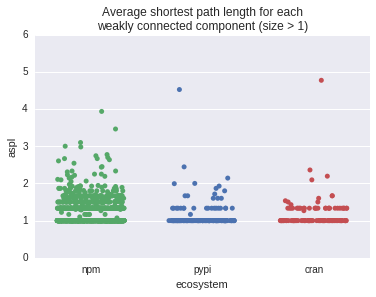

In [14]:
ax = seaborn.stripplot('ecosystem', 'aspl', data=df, jitter=0.3, 
                      order=COLORS.keys(), palette=list(COLORS.values()))
ax.set_title('Average shortest path length for each\nweakly connected component (size > 1)')

## Hubs and Authorities

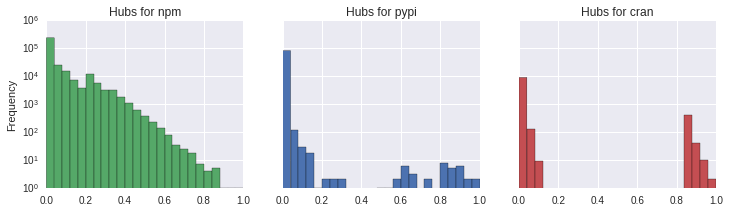

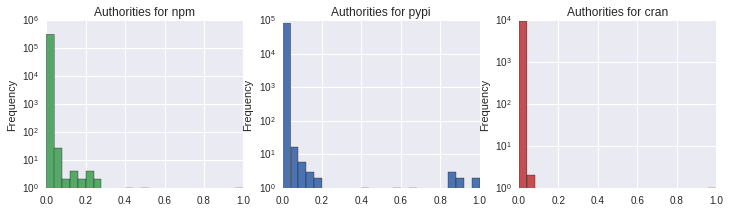

In [19]:
fig_hubs, ax_hubs = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_hubs.set_size_inches((12, 3))

fig_auth, ax_authorities = matplotlib.pyplot.subplots(ncols=3)
fig_auth.set_size_inches((12, 3))

for i, (ecos, graph) in enumerate(graphs.items()):
    hubs, authorities = graph.hub_score(), graph.authority_score()
    hubs, authorities = pandas.Series(hubs), pandas.Series(authorities)
    hubs.plot.hist(label=ecos, ax=ax_hubs[i], bins=25, logy=True, color=COLORS[ecos])
    authorities.plot.hist(label=ecos, ax=ax_authorities[i], bins=25, logy=True, color=COLORS[ecos])
    ax_hubs[i].set_title('Hubs for {}'.format(ecos))
    ax_authorities[i].set_title('Authorities for {}'.format(ecos))

## Pagerank

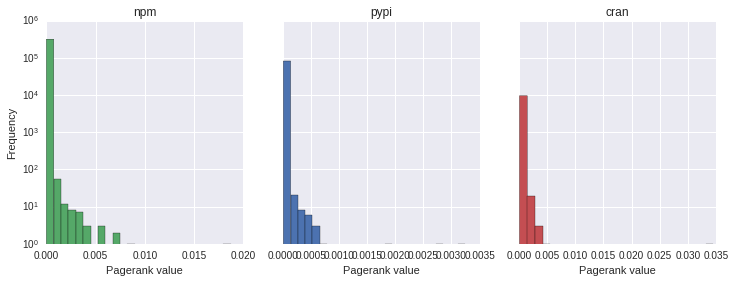

In [16]:
fig, axes = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig.set_size_inches((12, 4))

for i, (ecos, graph) in enumerate(graphs.items()):
    pagerank = graph.pagerank()
    pandas.Series(pagerank).plot.hist(label=ecos, ax=axes[i], bins=25, logy=True, color=COLORS[ecos])
    axes[i].set_title(ecos)
    axes[i].set_xlabel('Pagerank value')